# Intro and rationale

Since breast density decreases with age, and is consistent over time, we want to create an algorithm that predicts the age of a patient from digital mammograms, to then compare the predicted age with the actual age.

# Data preparation: 
Operational plan:
- We select patients with normal status, normal outcome, and no malignancy in their history. 
- Make sure we take an equal number of under 55 and over 55.
- We convert them to .png, divide them in two directories (under55 and over55).

We will both explore the scores of everything all together, plotting against age, side, Mirai score? whatever we can think, and then try to categorise them in the two age groups.


In [72]:
import pandas as pd 
import random

In [56]:
## reading the selection of screening studies we saved in summary_stats_optimam.ipynb 
screen_red_df2 = pd.read_csv('~/Projects/cruk-mammoai/summaries/selected_screening_reduced.csv', dtype={
 'Site': 'category',
 'EpisodeStatus': 'category',
 'EpisodeOutcome': 'category',
 'SOPInstanceUID': 'category',
 'NumberOfMarks': int,
 'Manufacturer': 'category',
 'Model': 'category',
 'ImageLaterality': 'category',
 'ViewPosition': 'category',
 'LesionSide':'category', 
 'PatientAgeYears':int, 
  }, parse_dates=['StudyDate'])


  ## reading the whole optimam dataset (to check malignancies in any point of the patients' history)
dataset = pd.read_csv('~/Projects/cruk-mammoai/summaries/summary-devversion.csv', dtype={
 'Site': 'category',
 'EpisodeID': 'category',
 'EpisodeStatus': 'category',
 'EpisodeOutcome': 'category',
 #'EpisodeIsPostOp': bool,
 'EpisodeType': 'category',
 'EpisodeAction': 'category',
 'EpisodeContainsMalignantOpinions': bool,
 'EpisodeContainsBenignOpinions': bool,
 'EpisodeHasEvents': bool,
 'EventType': 'category',
 'SeriesInstanceUID': 'category',
 'SOPInstanceUID': 'category',
 'NumberOfMarks': int,
 'Manufacturer': 'category',
 'Model': 'category',
 'PresentationIntentType': 'category',
 'ImageLaterality': 'category',
 'ViewPosition': 'category',
 'ViewModCodeValue': 'category',
 'ViewModCodeMeaning': 'category',
 'BodyPartThicknessMM': float,
 #'PatientAgeYears': int
  }, parse_dates=['EpisodeSortDate', 'EpisodeOpenedDate', 'EpisodeClosedDate', 'StudyDate' ])

history = pd.read_csv('~/Projects/cruk-mammoai/summaries/screening_history.csv')


/home/celeste/Projects/Breast_density_MammoAI/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
def description(dataset, ds_name):
    """
    Argument: (dataframe, operational name of the dataframe)
    They need to have fields:
    ClientID
    Site
    EpisodeOutcome
    StudyInstanceUID
    Manufacturer
    Model
    PatientAgeYears
    LesionSide

    Returns: 
    descriptive stats for the dataset
    """
    dataset.name = ds_name


    number_patients = dataset['ClientID'].nunique()
    number_studies = dataset['StudyInstanceUID'].nunique()
    number_entries = dataset['SOPInstanceUID'].nunique()


    print(f'In the dataset {dataset.name} there are: \n {number_patients} unique patients,   \n {number_studies} unique studies and \n {number_entries} images')

    print('-------------------------- \n')

    dataset.loc[(dataset.PatientAgeYears < 55),  'AgeGroup'] = '<55'
    dataset.loc[(dataset.PatientAgeYears >= 55)& (dataset.PatientAgeYears < 65),  'AgeGroup'] = '55-65'
    dataset.loc[(dataset.PatientAgeYears >= 65),  'AgeGroup'] = '65+'
    age_listing = dataset.groupby(['StudyInstanceUID'], as_index=False)['AgeGroup'].agg('first')
    age_distrib =age_listing.groupby('AgeGroup').count()
    age_distrib 


    print(f'In the dataset {dataset.name} we have the following age counts (one count per StudyInstanceUID):')
    print(age_distrib, '\n')
    print(age_distrib/age_distrib.sum())

    print('-------------------------- \n')


    for col in dataset[['Site', 'Model', 'Manufacturer']]:
        study_grouping = dataset.groupby(['StudyInstanceUID'], as_index=False)[col].agg('first')

        distribution =study_grouping[col].value_counts(dropna=False)
        distribution_percent = (study_grouping[col].value_counts(dropna=False))/(study_grouping[col].value_counts(dropna=False).sum())

        print(f'The patients in {dataset.name} are distributed among the following {col} (one count per StudyInstanceUID):')
        print(distribution, '\n')
        print(distribution_percent)
        print('--------------------------\n')
    

In [58]:
# make a list of all ClientID that have an MP or M  EpisodeOutcome 
# remove all entries that have ClientIDs in said list from the rest

list_malignant_outcome_patients = dataset.loc[dataset['EpisodeOutcome'].isin(['MP', 'M', 'CI', 'CIP']), 'ClientID'].tolist()
list_malignant = list(set(list_malignant_outcome_patients))
len(list_malignant)


7222

In [59]:
normal_df = screen_red_df2[(screen_red_df2['EpisodeOutcome']=='N')&(~screen_red_df2['ClientID'].isin(list_malignant))].copy().reset_index(drop=True)

## Selecting only complete studies

In [60]:
# Check we have how many images we have per study (but we still might have several studies per patient)
images_p_study = normal_df.groupby('StudyInstanceUID',  as_index=False)['SOPInstanceUID'].nunique()
number_images = images_p_study.groupby('SOPInstanceUID')['StudyInstanceUID'].count()
number_images

SOPInstanceUID
1       105
2       116
3        20
4     11451
5       924
6       110
7         4
8         5
10        1
Name: StudyInstanceUID, dtype: int64

In [61]:
# We take all the StudyInstanceUID with 4 images or more
four_plus = images_p_study[images_p_study['SOPInstanceUID'] >= 4].copy()
list_4_plus_images = list(set(four_plus['StudyInstanceUID'].tolist()))
normal_4plus_df = normal_df [normal_df['StudyInstanceUID'].isin(list_4_plus_images)].copy().reset_index(drop=True)

In [62]:
# Then we add a column with view-laterality
# and delete duplicates as to remain with just 4 images for each

normal_4plus_df['View+Side'] = normal_4plus_df['ViewPosition'].astype(str)+ normal_4plus_df['ImageLaterality'].astype(str)

# Now we drop duplicates. We keep the first as it is the most recent
normal_dupli_dropped = normal_4plus_df.drop_duplicates(['ClientID', 'Site', 'EpisodeStatus', 'EpisodeOutcome', 'StudyInstanceUID', 'ImageLaterality', 'ViewPosition', 'Model', 'PatientAgeYears', 'NumberOfMarks', 'LesionSide', 'View+Side'], keep='last')

# Check we have how many images we have per study now (but we still might have several studies per patient)

images_p_study2 = normal_dupli_dropped.groupby('StudyInstanceUID',  as_index=False)['SOPInstanceUID'].nunique()
number_images2 = images_p_study2.groupby('SOPInstanceUID')['StudyInstanceUID'].count()
number_images2

SOPInstanceUID
2        2
3        3
4    12490
Name: StudyInstanceUID, dtype: int64

In [63]:
#It seems that some studies had several duplicates but were not complete exams. 
# So now we select only the exams with that remained with exactly 4 images.

# Now that we don't have duplicates, we filter out again the studies with less than 4 images

four_images = images_p_study2[images_p_study2['SOPInstanceUID'] == 4].copy().reset_index(drop=True)
list_4_images = list(set(four_images['StudyInstanceUID'].tolist()))

normal_complete_studies_df = normal_dupli_dropped[normal_dupli_dropped['StudyInstanceUID'].isin(list_4_images)].copy().reset_index(drop=True)

## One exam per patient

In [40]:
# Check how many exams we have per patient

exam_pp = normal_complete_studies_df.groupby('ClientID',  as_index=False)['StudyInstanceUID'].nunique().copy()
number_exams = exam_pp.groupby('StudyInstanceUID')['ClientID'].count()
number_exams

StudyInstanceUID
1    4486
2    3898
3      68
4       1
Name: ClientID, dtype: int64

In [69]:
# let us make a summary with one line per study, in ascending order so we know how to take the oldest
summary_studies = normal_complete_studies_df[['ClientID', 'Site', 'StudyDate', 'StudyInstanceUID']].sort_values(["ClientID", "StudyDate"], ascending = (True, True)).copy().reset_index(drop=True)

# then we keep one line per client, the first one (oldest)
summary_studies_drop = summary_studies.drop_duplicates(['ClientID', 'Site'], keep='first')


# and we save in a list the StudyInstanceUIDs
list_selected_study = list(set(summary_studies_drop['StudyInstanceUID'].to_list()))

normal_studies_df = normal_complete_studies_df[normal_complete_studies_df['StudyInstanceUID'].isin(list_selected_study)].copy().reset_index(drop=True)

# now we check that in normal_studies_df we remain with just one study per patient

exam_pp2 = normal_studies_df.groupby('ClientID',  as_index=False)['StudyInstanceUID'].nunique().copy()
number_exams2 = exam_pp2.groupby('StudyInstanceUID')['ClientID'].count()
number_exams2

StudyInstanceUID
1    8453
Name: ClientID, dtype: int64

In [70]:
description(normal_studies_df, 'Normal complete studies, selected one per patient')

In the dataset Normal complete studies, selected one per patient there are: 
 8453 unique patients,   
 8453 unique studies and 
 33812 images
-------------------------- 

In the dataset Normal complete studies, selected one per patient we have the following age counts (one count per StudyInstanceUID):
          StudyInstanceUID
AgeGroup                  
55-65                 3749
65+                   1372
<55                   3332 

          StudyInstanceUID
AgeGroup                  
55-65             0.443511
65+               0.162309
<55               0.394180
-------------------------- 

The patients in Normal complete studies, selected one per patient are distributed among the following Site (one count per StudyInstanceUID):
jarv    4771
stge    3682
Name: Site, dtype: int64 

jarv    0.564415
stge    0.435585
Name: Site, dtype: float64
--------------------------

The patients in Normal complete studies, selected one per patient are distributed among the following Model (one

## Selecting samples per age group

In [74]:
# Since we have only 1372 over 65 (and 3332 under 55, and 3749 in between)
# we take 1300 from each age group

normal_under_55_temp = normal_studies_df[normal_studies_df['PatientAgeYears']<55]
list_under_55 = list(set(normal_under_55_temp['ClientID'].tolist()))
under_55_sample = random.sample(list_under_55, 1300)
normal_under_55_df = normal_under_55_temp[normal_under_55_temp['ClientID'].isin(under_55_sample)]

normal_55_65_temp = normal_studies_df[(normal_studies_df['PatientAgeYears']>=55)&(normal_studies_df['PatientAgeYears']<65)]
list_55_65 = list(set(normal_55_65_temp['ClientID'].tolist()))
bet_55_65_sample= random.sample(list_55_65, 1300)
normal_55_65_df = normal_55_65_temp[normal_55_65_temp['ClientID'].isin(bet_55_65_sample)]

normal_over_65_temp = normal_studies_df[(normal_studies_df['PatientAgeYears']>=65)]
list_over_65 = list(set(normal_over_65_temp['ClientID'].tolist()))
over_65_sample = random.sample(list_over_65, 1300)
normal_over_65_df = normal_over_65_temp[normal_over_65_temp['ClientID'].isin(over_65_sample)]




## Saving age group datasets

In [79]:
compression_opts_55 = dict(method='zip', archive_name='normal_under55.csv')  
normal_under_55_df.to_csv('~/Projects/TDA_breast_density/Data/lookup/normal_under55.zip',  index=False, compression= compression_opts_55)

compression_opts_55_65 = dict(method='zip', archive_name='normal_55_to_65.csv')  
normal_55_65_df.to_csv('~/Projects/TDA_breast_density/Data/lookup/normal_55_to_65.zip',  index=False, compression= compression_opts_55_65)

compression_opts_65 = dict(method='zip', archive_name='normal_over65.csv')  
normal_over_65_df.to_csv('~/Projects/TDA_breast_density/Data/lookup/normal_over65.zip',  index=False, compression= compression_opts_65)

## Images conversion

In [238]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_windowing, apply_voi_lut, apply_voi
import os
import cv2
import numpy as np
import math as ma
import matplotlib.pyplot as plt
import ast
import itertools
import operator
from PIL import Image


In [239]:
# Working directories
OMI_DB_directory = "/home/celeste/data8/optimam/main/image_db/sharing/omi-db/images/" # here we have one directory per patient, each with a subdirectory for each study

under_55_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_under55/'
if not os.path.exists(under_55_dir):
    os.makedirs(under_55_dir)
    
between_55_to_65_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_55_to_65/'
if not os.path.exists(between_55_to_65_dir):
    os.makedirs(between_55_to_65_dir)

over_65_dir = '/home/celeste/Projects/TDA_breast_density/Data/images/normal_over65/'
if not os.path.exists(over_65_dir):
    os.makedirs(over_65_dir)

In [240]:
normal_under55 =  pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_under55.csv')
normal_55_to_65 = pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_55_to_65.csv')
normal_over65 = pd.read_csv('~/Projects/TDA_breast_density/Data/lookup/normal_over65.csv')


In [241]:
# making the three lists of dicoms belonging to the selected dataset
list_paths_under_55 = OMI_DB_directory + normal_under55['ClientID'].astype(str) +  '/' + normal_under55['StudyInstanceUID'].astype(str)+ '/' + normal_under55['SOPInstanceUID'].astype(str) + '.dcm'
list_paths_55_to_65 = OMI_DB_directory + normal_55_to_65['ClientID'].astype(str) +  '/' + normal_55_to_65['StudyInstanceUID'].astype(str)+ '/' + normal_55_to_65['SOPInstanceUID'].astype(str) + '.dcm'
list_paths_over_65 = OMI_DB_directory + normal_over65['ClientID'].astype(str) +  '/' + normal_over65['StudyInstanceUID'].astype(str)+ '/' + normal_over65['SOPInstanceUID'].astype(str) + '.dcm'


In [242]:
# ## we need to understand the sizes

# list_heights_55 = []
# list_width_55 = []

# for item in list_paths_under_55[:500]:
#     dicom = pydicom.read_file(item)
#     img = dicom.pixel_array.astype(int)
#     list_heights_55.append(img.shape[0])
#     list_width_55.append(img.shape[1])
    


# def most_frequent(List):
#     return max(set(List), key = List.count)

# print(most_frequent(list_heights_55))

    

### Auxiliary functions for normalising and resising

In [250]:
def img_original_raw_or_not(fn_or_dicom):
    # Corrects the encoding (MONOCHROME) and applies the rescale slope and intercept if tags are present
    # Using new functions from pydicom library
    # The functions `apply_modality_lut`, `apply_voi` and `apply_windowing` 
    # return the numpy array unchanged on raw DICOMS 
    # because the tags required bu these functions are missing.

    if isinstance(fn_or_dicom, str):
        dicom = pydicom.read_file(fn_or_dicom)
    elif isinstance(fn_or_dicom, pydicom.dataset.FileDataset):
        dicom = fn_or_dicom
    else:
        raise Exception(
            'fn_or_dicom is not a file name or dicom object. Type(fn_or_dicom)={}'.format(type(fn_or_dicom)))
    
    img = apply_modality_lut(dicom.pixel_array, dicom).astype(int)
    
    if dicom.PresentationIntentType == 'FOR PRESENTATION':

        inverse_pls = False
        if 'PresentationLUTShape' in dicom:
            if dicom.PresentationLUTShape == 'INVERSE':
                img = apply_windowing(img, dicom).astype(int)
                inverse_pls = True

        if inverse_pls:
            
            img = apply_voi(img, dicom)  ## no lut
        else:
            img = apply_voi_lut(img, dicom)

        if 'PhotometricInterpretation' in dicom:
            if dicom.PhotometricInterpretation == 'MONOCHROME1':
                img = img.max() - img
                
        
    elif dicom.PresentationIntentType == 'FOR PROCESSING':

        inverse_pls = False
        if 'PresentationLUTShape' in dicom:
            if dicom.PresentationLUTShape == 'INVERSE':
                # (0028,1050) Window Center and (0028,1051) Window Width not present
                # so leaves the array unchanged
                img = apply_windowing(img, dicom).astype(int)
                inverse_pls = True
                
        # VOI LUT attribute required only if Presentation Intent Type (0008,0068) is FOR PRESENTATION
        # ...so here leaves the array unchanged
        if inverse_pls:
            img = apply_voi(img, dicom)  ## no lut
        else:
            img = apply_voi_lut(img, dicom)
        
        # this is the only bit that does something in 'FOR PROCESSING'
        if 'PhotometricInterpretation' in dicom:
            if dicom.PhotometricInterpretation == 'MONOCHROME1':
                img = img.max() - img
        
    # Some images have 3 channels (error images):
    if img.ndim > 2:
        print('WARNING: Image with more than 1 channel. Applying rgb2gray transformation')
        # img = imgu.rgb2gray(img)


    # print("This image is " + str(dicom.PresentationIntentType) + "; Presentation LUT shape " + str(dicom.PresentationLUTShape) + "; and Photometric Interpretation " + str(dicom.PhotometricInterpretation))
    return img.astype(int)

    

def img_norm_raw(fn_or_dicom, ymin=0, ymax=255):
    # For presentation: normalizes the image to the range [ymin,ymax])
    # For processing: removes background, windows, normalizes the image to the range [ymin,ymax]
    # Returns: a list (numpy array, string)
    # where the string is the filename to save it


    if isinstance(fn_or_dicom, str):
        dicom = pydicom.read_file(fn_or_dicom)
    elif isinstance(fn_or_dicom, pydicom.dataset.FileDataset):
        dicom = fn_or_dicom
    else:
        raise Exception(
            'fn_or_dicom is not a file name or dicom object. Type(fn_or_dicom)={}'.format(type(fn_or_dicom)))
    
    img = img_original_raw_or_not(dicom)
        
    # Checking if the image is 'FOR PROCESSING' or 'FOR PRESENTATION'
    if (dicom.PresentationIntentType=='FOR PRESENTATION'):

        ## Normalisation 
        imgNorm = cv2.normalize(img, None, ymin, ymax, cv2.NORM_MINMAX) 

        return imgNorm.astype('float32')
    
    elif (dicom.PresentationIntentType=='FOR PROCESSING'):
        
        
        img255 = (255*(img/float(np.max(img)))).astype('uint8')  


        #removing the background
        ret,th = cv2.threshold(img255,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binary = 1*(img255<ret)
        imgm = ma.masked_array(img, mask=binary) #apply mask
        #img1 = ma.masked_array(np.maximum(np.ones_like(imgm), imgm)), mask=binary) #log transform

        ## windowing quantiles
        myquants=mquantiles(imgm.compressed(), [0,0.1,0.25,0.5,0.75,0.85,1]).tolist()
    
        ## windowing
        mymin=np.ones_like(imgm) * (myquants[2]) ##don't window white
        #myzero=np.zeros_like(imgm)
        
        img2 = ma.masked_array(np.maximum(mymin, img)- myquants[2] , mask=binary) ##don't window white
        
        ## fill the white 
        imgb = img2.filled(np.min(img))
        imgb = imgb.astype('float32')
        
        ### Normalisation 
        imgNorm = cv2.normalize(imgb, None, ymin, ymax, cv2.NORM_MINMAX) 

        ### Name that we will use to save it
        filename = dicom.PatientID + dicom.ViewPosition + dicom.ImageLaterality + dicom.AcquisitionDate

        return [imgNorm.astype('float32'), filename] 
    
    else:
        raise Exception(
        'This dicom is neither FOR PRESENTATION nor FOR PROCESSING')


def img_resize(img, shapeImgOut=(1024, 787), resizeMethod='span', resampleMethod='NEAREST', position='left'):
    # It resizes the input image to the size sizeImgOut with:
    # resizeMethod in {padding, span}
    # The padding option resizes the longest side of the pixel array and rescale the image 
    # maintaining the original ratio. 
    # Then creates a black square and pastes the rescaled image on it, 
    # on the left handside of the square (commented code to change this behaviour).
    # resampleMethod should be a method accepted by Image.resize:
    # (0) PIL.Image.NEAREST
    # (4) PIL.Image.BOX
    # (2) PIL.Image.BILINEAR
    # (5) PIL.Image.HAMMING
    # (3) PIL.Image.BICUBIC
    # (1) PIL.Image.LANCZOS
    # position can be 'centre' (padding on both sides) or 'left'(padding on right side)
    # returns (numpy array)

    if isinstance(shapeImgOut, int):
        # Per output quadrato:
        # shapeImgOut = (shapeImgOut, shapeImgOut)

        # the following keeps ratio if we set by default, 
        # shapeImgOut=1024 in the def.
        # But we have different ratios in optimam
        # we end up with images with same height and different width.
        # shapeImgOut = (shapeImgOut,ma.floor((img.shape[1]*shapeImgOut)/img.shape[0]))
        shapeImgOut = (shapeImgOut[0], shapeImgOut[1])

    sizeImgOut = shapeImgOut[::-1]

    if resizeMethod == 'padding':
        divMax = max(img.shape[0] / shapeImgOut[0], img.shape[1] / shapeImgOut[1])
        print(divMax)
        sizeResize = (int(img.shape[1] / divMax), int(img.shape[0] / divMax))
    else:
        sizeResize = sizeImgOut


    typeImgIn = img.dtype
    img = Image.fromarray(img.astype(np.uint8))
    img = img.resize(sizeResize, resample=getattr(Image, resampleMethod))

    if resizeMethod == 'padding':
        # PIL.Image.new(mode, size, color) creates a new image with the given mode and size  
        # L is (8-bit pixels, black and white)
        # Size is given as a (width, height)-tuple
        # default colour is 0
        out_img = Image.new('L', sizeImgOut)   
        # Image.paste(im, box=None, mask=None)
        
        if position == 'centre':
            out_img.paste(img, ((sizeImgOut[0] - img.size[0]) // 2, (sizeImgOut[1] - img.size[1]) // 2))
        else:
            out_img.paste(img, (0, 0))
    else:
        out_img = img

    return np.array(out_img).astype(typeImgIn)

In [251]:
example = list_paths_under_55[542]
example2 = list_paths_under_55[1]
example3 = list_paths_under_55[2]
example4 = list_paths_under_55[3]

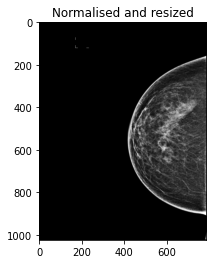

Normalised and resized img shape: (1024, 787)


In [254]:
#def img_resize(img, shapeImgOut=1024, resizeMethod='span', resampleMethod='NEAREST', position='left'):

resized_img = img_resize(img_norm_raw(example), shapeImgOut=(1024,787), resizeMethod='span', resampleMethod='NEAREST', position='left')
plt.imshow(resized_img, cmap='gray')
plt.title("Normalised and resized")
plt.show()
print ('Normalised and resized img shape:', resized_img.shape)


### Batch saving as .png

In [259]:
def Processing(listDCM, OutputDir, shapeOut=(1024, 787)):
    """
    Args: (a list of paths of .dcm images, 
    path of directory where to save output,
    the size in pixel of the output images)
    Returns: None (it will have saved the pixel_arrays 
    of the dicoms as png in the specified directory)
    """

    for file in listDCM:
        print(file)
                
        processed_array = img_resize(img_norm_raw(file), shapeImgOut=shapeOut)
        image = Image.fromarray(processed_array)
            
        ### stacking in 3 channels - use np.stack for more flexibility
        #image3chan = np.stack([imgb_resized]*3, axis=0)
        #image3chan = image.convert('RGB')
        
        image.save(OutputDir + filename + '.png')
        
    return None

In [261]:
list_under_55[0]

'demd27825'

In [260]:
Processing(list_paths_under_55, under_55_dir)

Processing(list_paths_55_to_65, between_55_to_65_dir)
Processing(list_paths_over_65, over_65_dir)


demd27825


FileNotFoundError: [Errno 2] No such file or directory: 'demd27825'

# Algorithms 
DAAR topology 

https://arxiv.org/pdf/2201.02295.pdf

Persistent Homology for Breast Tumor Classification using Mammogram Scans